# AST 4930 Week 4

## Cross validation, parameter optimization, evaluation metric

### Let's load the iris data and run cross validation.

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_validate

iris = load_iris()
model = DecisionTreeClassifier(max_depth=4, random_state=0)

scores = cross_val_score(model, iris.data, iris.target, cv=5)
print("Cross-validation scores: {}".format(scores))
print("Mean cross-validation scores: {:.3f}".format(scores.mean()))
print("Standard deviation cross-validation scores: {:.3f}".format(scores.std()))

Cross-validation scores: [0.96666667 0.96666667 0.9        1.         1.        ]
Mean cross-validation scores: 0.967
Standard deviation cross-validation scores: 0.037


### Let's split the data for hyperparameter optimization.

In [3]:
from sklearn.model_selection import train_test_split

X = iris.data
y = iris.target

#If you want to reproduce the result, make sure you use the same random_state value.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### We can use for loops.

In [4]:
import numpy as np

max_depth = np.arange(10)+1
criterion = ['gini','entropy']

best_score = 0

for i in max_depth:
    for j in criterion:
        model = DecisionTreeClassifier(max_depth=i, criterion=j, random_state=0)
        score = cross_val_score(model, X_train, y_train, cv=5)
        score = np.mean(score)
        if score > best_score:
            best_score = score
            best_parameters = {'max_depth': i, 'criterion': j}
    
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Best score: 0.96
Best parameters: {'max_depth': 3, 'criterion': 'gini'}


### But we can take advantage of built-in modules.

In [5]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': np.arange(10)+1,
              'criterion': ['gini','entropy']}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, cv=5, 
                           return_train_score=True, verbose=1)
grid_search.fit(X_train, y_train)

print("Test score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best model: {}".format(grid_search.best_estimator_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Test score: 0.97
Best parameters: {'criterion': 'gini', 'max_depth': 3}
Best model: DecisionTreeClassifier(max_depth=3, random_state=0)


### Let's make a heatmap.

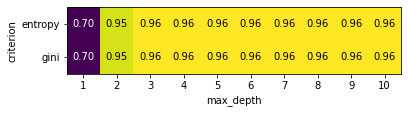

In [6]:
import pandas as pd
import mglearn
#If you haven't installed mglearn on HiPerGator, 
#install the module by typing "!pip install mglearn" and restart the kernel

results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(2,10)

mglearn.tools.heatmap(scores, xlabel='max_depth', xticklabels=param_grid['max_depth'],
                     ylabel='criterion', yticklabels=param_grid['criterion'], cmap='viridis')

### What if we need feature scaling?

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('sc', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {'knn__n_neighbors': np.arange(10)+1,
              'knn__weights': ['uniform','distance']}

grid_search = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True, verbose=1)
grid_search.fit(X_train, y_train)

print("Test score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best model: {}".format(grid_search.best_estimator_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Test score: 0.97
Best parameters: {'knn__n_neighbors': 5, 'knn__weights': 'distance'}
Best model: Pipeline(steps=[('sc', StandardScaler()),
                ('knn', KNeighborsClassifier(weights='distance'))])


### Let's load the SDSS data we used last week and test parallelization.

In [8]:
data = np.load('/blue/ast4930/share/SDSS_example.npz')['data']

# Extract colors and spectral class
ug = data['u'] - data['g']
gr = data['g'] - data['r']
ri = data['r'] - data['i']
iz = data['i'] - data['z']
spec_class = data['specClass']

# Separating galaxies and quasars
galaxies = (spec_class == 'GALAXY')
qsos = (spec_class == 'QSO')

# X for an array containing features (i.e., colors)
X = np.array([ug, gr, ri, iz]).T

# y for an array containing labels (i.e., galaxies or quasars)
y = np.expand_dims(spec_class, axis=1)

#If you want to reproduce the result, make sure you use the same random_state value.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)



### Hyperparameter optimization with 1 CPU core

In [9]:
import time

tstart = time.time()

param_grid = {'max_depth': np.arange(30)+1,
              'criterion': ['gini','entropy']}

# By defaults, sklearn's GridSearchCV will use stratified k-fold for classification problems.
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, return_train_score=True, 
                           verbose=1)
grid_search.fit(X_train, y_train)

print("Test score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best model: {}".format(grid_search.best_estimator_))
print("Elapsed time: {:.3f}".format(time.time()-tstart) + " seconds")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Test score: 0.99
Best parameters: {'criterion': 'gini', 'max_depth': 5}
Best model: DecisionTreeClassifier(max_depth=5)
Elapsed time: 81.969 seconds


### Now the same task with 2 CPU cores

In [10]:
tstart = time.time()

param_grid = {'max_depth': np.arange(30)+1,
              'criterion': ['gini','entropy']}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, return_train_score=True, 
                           n_jobs=2, verbose=1)
grid_search.fit(X_train, y_train)

print("Test score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best model: {}".format(grid_search.best_estimator_))
print("Elapsed time: {:.3f}".format(time.time()-tstart) + " seconds")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Test score: 0.99
Best parameters: {'criterion': 'entropy', 'max_depth': 7}
Best model: DecisionTreeClassifier(criterion='entropy', max_depth=7)
Elapsed time: 48.118 seconds


### Imbalanced data and evaluation metric

Counter({0: 9001, 1: 999})


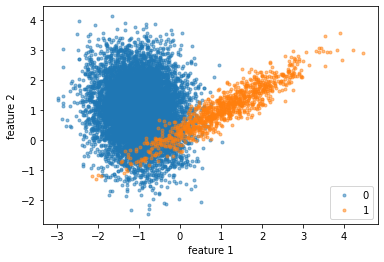

In [25]:
from collections import Counter
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# generate imbalanced dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.9], flip_y=0, random_state=2)

# summarize class distribution
counter = Counter(y)
print(counter)

# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label), alpha=0.5, marker='.')

plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(loc='lower right')

### Split the data.

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [27]:
param_grid = {'max_depth': np.arange(30)+1,
              'criterion': ['gini','entropy']}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, cv=5, 
                           return_train_score=True, verbose=1, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Test score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best model: {}".format(grid_search.best_estimator_))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Test score: 0.97
Best parameters: {'criterion': 'gini', 'max_depth': 3}
Best model: DecisionTreeClassifier(max_depth=3, random_state=0)


In [28]:
## ** operator takes a dictionary and unpack it into keaword arguments in a function.
model = DecisionTreeClassifier(**grid_search.best_params_, random_state=0)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

### This is the true class.

Counter({0: 2256, 1: 244})


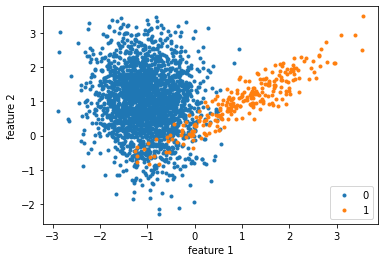

In [29]:
counter = Counter(y_test)
print(counter)

# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y_test == label)[0]
    plt.scatter(X_test[row_ix, 0], X_test[row_ix, 1], label=str(label), alpha=1, marker='.')

plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(loc='lower right')

### This is our best model. Are we good with it?

Counter({0: 2298, 1: 202})


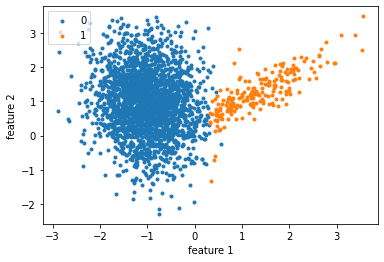

In [30]:
prediction = model.predict(X_test)

counter = Counter(prediction)
print(counter)

# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(prediction == label)[0]
    plt.scatter(X_test[row_ix, 0], X_test[row_ix, 1], label=str(label), alpha=1, marker='.')

plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(loc='upper left')


### Let's check out different evaluation metric

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2256
           1       0.93      0.77      0.84       244

    accuracy                           0.97      2500
   macro avg       0.95      0.88      0.91      2500
weighted avg       0.97      0.97      0.97      2500



### I'd like to minimize false negatives. Let's use "recall" as the evaluation metric.

In [32]:
param_grid = {'max_depth': np.arange(30)+1,
              'criterion': ['gini','entropy']}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, cv=5, 
                           return_train_score=True, verbose=1, scoring='recall')

grid_search.fit(X_train, y_train)

print("Test score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best model: {}".format(grid_search.best_estimator_))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Test score: 0.82
Best parameters: {'criterion': 'entropy', 'max_depth': 24}
Best model: DecisionTreeClassifier(criterion='entropy', max_depth=24, random_state=0)


In [33]:
model = DecisionTreeClassifier(**grid_search.best_params_, random_state=0)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=24, random_state=0)

### Is it any better?

Counter({0: 2254, 1: 246})


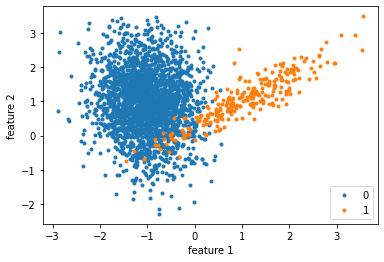

In [35]:
prediction = model.predict(X_test)

counter = Counter(prediction)
print(counter)

# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(prediction == label)[0]
    plt.scatter(X_test[row_ix, 0], X_test[row_ix, 1], label=str(label), alpha=1, marker='.')

plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(loc='lower right')


In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2256
           1       0.82      0.82      0.82       244

    accuracy                           0.96      2500
   macro avg       0.90      0.90      0.90      2500
weighted avg       0.96      0.96      0.96      2500



## Astrophysical Implications: imbalanced data

### We will use Planetary Habitability Laboratory data: http://phl.upr.edu/projects/habitable-exoplanets-catalog/data/database

In [281]:
df = pd.read_csv('/blue/ast4930/share/phl_exoplanet_catalog.csv', sep = ',')

In [282]:
df

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007,2014-05-14,...,0,Hot,0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.863300,1.29000
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009,2018-09-06,...,0,Hot,0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.784800,1.53000
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008,2014-05-14,...,0,Hot,0,0.081917,Andromeda,And,Andromeda,12.848516,1525.574400,0.83000
3,14 Her b,3.0,1481.07850,-47.67420,47.67420,NaN,NaN,NaN,2002,2018-09-06,...,0,Cold,0,0.145241,Hercules,Her,Hercules,12.865261,1481.078500,2.93000
4,16 Cyg B b,3.0,565.73385,-25.42624,25.42624,NaN,NaN,NaN,1996,2018-09-06,...,1,Warm,0,0.368627,Cygnus,Cyg,Swan,13.421749,565.733850,1.66000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4043,K2-296 b,3.0,NaN,NaN,NaN,1.87,0.45,0.2,2019,5/23/19,...,0,Warm,2,0.755038,Virgo,Vir,Virgin,1.870000,4.155456,0.13456
4044,K2-296 c,3.0,NaN,NaN,NaN,2.76,NaN,NaN,2019,5/23/19,...,0,Hot,0,0.363831,Virgo,Vir,Virgin,2.760000,8.047485,0.05769
4045,GJ 1061 b,3.0,1.38000,0.15000,0.16000,NaN,NaN,NaN,2019,9/3/19,...,0,Hot,0,0.588562,Horologium,Hor,Pendulum Clock,1.102775,1.380000,0.02100
4046,GJ 1061 c,3.0,1.75000,0.23000,0.23000,NaN,NaN,NaN,2019,9/3/19,...,0,Warm,1,0.879042,Horologium,Hor,Pendulum Clock,1.178333,1.750000,0.03500


In [283]:
df.columns

Index(['P_NAME', 'P_STATUS', 'P_MASS', 'P_MASS_ERROR_MIN', 'P_MASS_ERROR_MAX',
       'P_RADIUS', 'P_RADIUS_ERROR_MIN', 'P_RADIUS_ERROR_MAX', 'P_YEAR',
       'P_UPDATED',
       ...
       'P_HABZONE_CON', 'P_TYPE_TEMP', 'P_HABITABLE', 'P_ESI',
       'S_CONSTELLATION', 'S_CONSTELLATION_ABR', 'S_CONSTELLATION_ENG',
       'P_RADIUS_EST', 'P_MASS_EST', 'P_SEMI_MAJOR_AXIS_EST'],
      dtype='object', length=112)

In [284]:
df.describe()

,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_PERIOD,P_PERIOD_ERROR_MIN,...,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_HABITABLE,P_ESI,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
count,4048.0,1598.000000,1467.000000,1467.000000,3139.000000,3105.000000,3105.000000,4048.000000,3.938000e+03,3.807000e+03,...,3786.000000,3.083000e+03,3281.000000,4048.000000,4048.000000,4048.000000,3721.000000,4048.000000,4048.000000,3978.000000
mean,3.0,798.384920,-152.292232,190.289692,4.191426,-0.483990,0.621867,2014.212945,2.309342e+03,-1.073631e+03,...,3.513348,1.768991e+35,0.440103,0.049654,0.034091,0.021986,0.261252,5.588647,323.089993,4.011385
std,0.0,1406.808654,783.366353,1082.061976,4.776830,1.409048,2.007592,3.704839,1.167012e+05,5.943181e+04,...,5.463171,6.944274e+36,0.074285,0.217256,0.181485,0.195731,0.131333,5.392733,965.084290,62.389968
min,3.0,0.019070,-24965.390000,0.000000,0.336300,-54.592700,0.000000,1989.000000,9.070629e-02,-3.650000e+06,...,0.002405,7.293660e-05,0.030707,0.000000,0.000000,0.000000,0.006768,0.000000,0.000000,0.004400
25%,3.0,26.548968,-79.457001,4.449592,1.569400,-0.526870,0.145730,2014.000000,4.497336e+00,-1.129000e-03,...,1.740762,5.264169e-01,0.420337,0.000000,0.000000,0.000000,0.196982,1.703920,3.628101,0.053000
50%,3.0,273.332080,-24.154928,25.108412,2.331680,-0.235410,0.325090,2016.000000,1.187053e+01,-9.392000e-05,...,2.568600,1.429118e+00,0.448357,0.000000,0.000000,0.000000,0.271192,2.667980,7.815324,0.102199
75%,3.0,806.488560,-4.392383,85.813561,3.553570,-0.134520,0.661390,2016.000000,4.186661e+01,-1.594000e-05,...,3.661581,2.641037e+00,0.472140,0.000000,0.000000,0.000000,0.303346,11.770500,149.379160,0.260507
max,3.0,17668.059000,0.270000,26630.808000,77.349000,0.450000,68.919080,2019.000000,7.300000e+06,3.200000e-02,...,104.112780,2.726899e+38,1.322542,1.000000,1.000000,2.000000,0.931208,77.349000,17668.059000,2500.000000


### This is a very imbalanced dataset if we are concerned about the habitability of the planets!

In [285]:
df.groupby('P_HABITABLE').count()
#P_HABITABLE - planet is potentially habitable index (1 = conservative, 2 = optimistic) 

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
P_HABITABLE,,,,,,,,,,,,,,,,,,,,,
0,3993,3993,1575,1444,1444,3101,3067,3067,3993,3993,...,3993,3993,3666,3666,3993,3993,3993,3993,3993,3923
1,21,21,16,16,16,9,9,9,21,21,...,21,21,21,21,21,21,21,21,21,21
2,34,34,7,7,7,29,29,29,34,34,...,34,34,34,34,34,34,34,34,34,34


In [286]:
#Creating a new data frame called bindf and droppoing the old habitability tag
bindf = df.drop('P_HABITABLE', axis = 1)

#Creating my new habitability tag
bindf['P_HABITABLE'] = (np.logical_or((df.P_HABITABLE == 1) , (df.P_HABITABLE == 2)))

#Re-casting this column as integer
bindf['P_HABITABLE'] = bindf['P_HABITABLE'].astype(int) 


### Let's select some features.

In [287]:
final_features = bindf[['S_MASS', 'P_PERIOD', 'P_DISTANCE']] 

In [288]:
final_features

,S_MASS,P_PERIOD,P_DISTANCE
0,2.70,326.030000,1.324418
1,2.78,516.219970,1.534896
2,2.20,185.840000,0.830000
3,0.90,1773.400000,3.130558
4,1.08,798.500000,2.043792
...,...,...,...
4043,0.41,28.165600,0.134560
4044,0.41,7.906961,0.057690
4045,0.12,3.204000,0.021000
4046,0.12,6.689000,0.035000


In [289]:
final_features.describe()

,S_MASS,P_PERIOD,P_DISTANCE
count,3283.000000,3.938000e+03,3978.000000
mean,1.003838,2.309342e+03,4.047677
std,0.652903,1.167012e+05,62.435994
min,0.010000,9.070629e-02,0.004408
25%,0.810000,4.497336e+00,0.053110
50%,0.970000,1.187053e+01,0.103000
75%,1.130000,4.186661e+01,0.263415
max,23.560000,7.300000e+06,2500.000000


In [290]:
targets = bindf.P_HABITABLE

### Do you see anything odd in the table above? There are less than 4048 counts. What about std, min, max values?

In [291]:
final_features.S_MASS.isnull().sum()

765

In [292]:
#For example...
final_features.S_MASS[920:930]

920    1.15
921    1.15
922    1.15
923     NaN
924     NaN
925     NaN
926     NaN
927    2.10
928    0.92
929    1.23
Name: S_MASS, dtype: float64

### We need to get rid of the data points with missing numbers.

In [293]:
#gets rid of any instance with at least one NaN in any column
final_features = final_features.dropna(axis = 0) 
final_features.shape

(3180, 3)

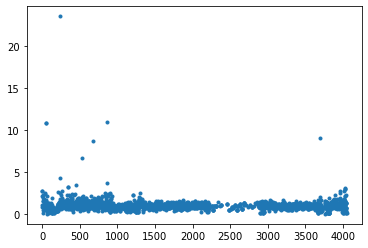

In [294]:
plt.plot(final_features.S_MASS,'.')

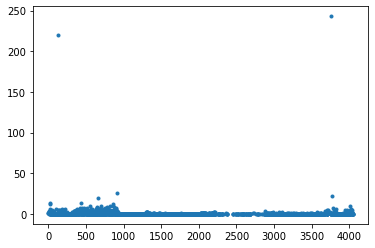

In [295]:
plt.plot(final_features.P_DISTANCE,'.')

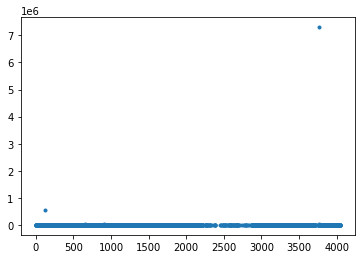

In [296]:
plt.plot(final_features.P_PERIOD,'.')

### Let's eliminate > 5 sigma outliers.

In [297]:
from scipy import stats

final_features = final_features[(np.abs(stats.zscore(final_features)) < 5).all(axis=1)] 

### How many data points are left?

In [298]:
final_features.shape

(3171, 3)

### Now, let's take only valid targets.

In [299]:
targets

0       0
1       0
2       0
3       0
4       0
       ..
4043    1
4044    0
4045    0
4046    1
4047    1
Name: P_HABITABLE, Length: 4048, dtype: int64

In [300]:
targets = targets[final_features.index]

### Let's make sure that we have the same number of targets.

In [301]:
targets

0       0
1       0
2       0
3       0
4       0
       ..
4043    1
4044    0
4045    0
4046    1
4047    1
Name: P_HABITABLE, Length: 3171, dtype: int64

In [302]:
targets.shape

(3171,)

### Reset the index.

In [303]:
final_features = final_features.reset_index(drop=True)
targets = targets.reset_index(drop=True)

In [333]:
targets

0       0
1       0
2       0
3       0
4       0
       ..
3166    1
3167    0
3168    0
3169    1
3170    1
Name: P_HABITABLE, Length: 3171, dtype: int64

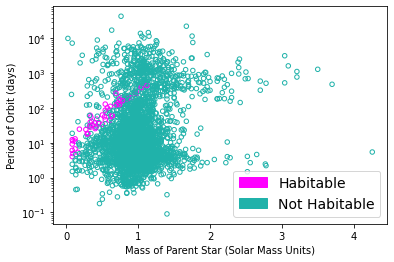

In [317]:
import matplotlib
import matplotlib.patches as mpatches

plt.figure(figsize=(6,4))

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#20B2AA','#FF00FF'])

a = plt.scatter(final_features['S_MASS'], final_features['P_PERIOD'], marker = 'o',\
            c = targets, s = 20, cmap=cmap, label = 'Test')

plt.legend();

a.set_facecolor('none')

plt.yscale('log')
plt.xlabel('Mass of Parent Star (Solar Mass Units)')
plt.ylabel('Period of Orbit (days)');

bluepatch = mpatches.Patch(color='#20B2AA', label='Not Habitable')
magentapatch = mpatches.Patch(color='#FF00FF', label='Habitable')

ax = plt.gca()
leg = ax.get_legend()

plt.legend(handles=[magentapatch, bluepatch],\
           loc = 'lower right', fontsize = 14);

### Let's use DT and build a model.

In [342]:
X_train, X_test, y_train, y_test = train_test_split(final_features, targets, random_state = 0)

In [343]:
model = DecisionTreeClassifier(random_state = 0)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9836065573770492

### The model looks great, but is it really?

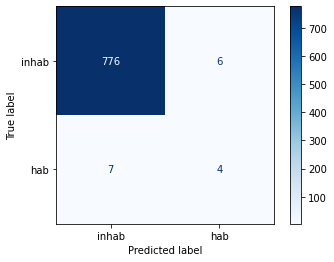

In [344]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(model.predict(X_test), y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['inhab', 'hab'])
disp.plot(cmap='Blues')

In [345]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       783
           1       0.36      0.40      0.38        10

    accuracy                           0.98       793
   macro avg       0.68      0.70      0.69       793
weighted avg       0.98      0.98      0.98       793



### It turned out that the high accuracy is because we have so many inhabitable planets in the data...

## Can cross validation and hyperparameter optimization help here?

### Optional, but extra credit 5pts to homework assignment if you can recover >= 80 % of habitable planets! 
### Due: Dec. 9.